#  Student Exam Scores Prediction

### Problem statement:

With the proliferation of data‐driven methodologies in education, institutions are turning to predictive analytics to support student achievement and optimize resource allocation. Underperforming students face diminished academic and career prospects, and schools incur significant costs addressing remediation and dropout prevention. Early and accurate prediction of exam performance is therefore essential to enable timely, targeted interventions. In this project, we develop a machine learning pipeline that leverages features such as hours studied, attendance rates, and past grades to forecast student exam scores with high precision. Our objective is to provide educators with actionable insights that facilitate personalized support and improve overall educational outcomes.

#### In this project:

1. Exploratory Data Analysis will be performed to figure out features with the most correlation to student exam scores. 


2. Custom **Linear Regression** (Mini-batch Gradient Descent) and **k-Nearest Neighbors** Regression models will be implemented **from scratch** to predict student performance.


3. Models' hyperparameters will be tuned to achieve the ultimate prediction performance. 


4. Both models will be benchmarked using k-fold cross-validation via mean absolute error (MAE) and R² to determine the top performer.

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import kagglehub
import seaborn as sns
import scipy.stats as stats

In [2]:
path = kagglehub.dataset_download("lainguyn123/student-performance-factors")

df = pd.read_csv(path + '/StudentPerformanceFactors.csv')

## EDA

In [3]:
df.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [4]:
X = df.iloc[:, :-1]
X.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female


As we can see, there's plenty of features. We'll do some correlation tests to reduce dimensionality for better performance later.

But before that, let's take a look whether the exam scores are evenly distributed.

### Target variable distribution

count    6607.000000
mean       67.235659
std         3.890456
min        55.000000
25%        65.000000
50%        67.000000
75%        69.000000
max       101.000000
Name: Exam_Score, dtype: float64


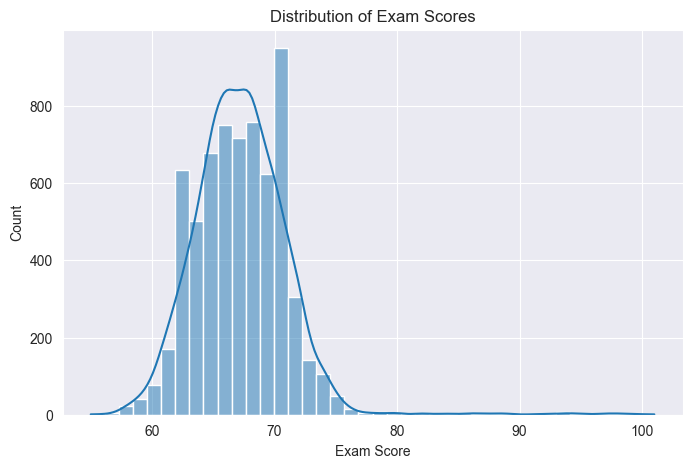

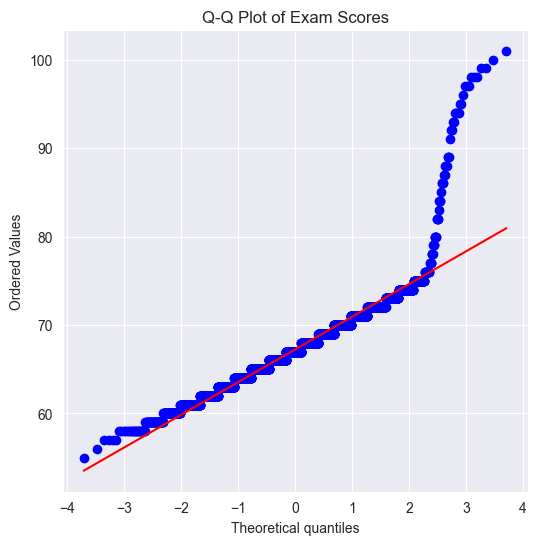

In [5]:
Y = df['Exam_Score']

print(Y.describe())

plt.figure(figsize=(8, 5))
sns.histplot(Y, kde=True, bins=40)
plt.title('Distribution of Exam Scores')
plt.xlabel('Exam Score')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(6, 6))
stats.probplot(Y, dist='norm', plot=plt)
plt.title('Q-Q Plot of Exam Scores')
plt.show()

#### As we can see:
1. The data pretty much follows the normal distribution in the middle-range (say from the 20th to 80th percentile), however there are some outliers in the lower end, and much more on the higher end.
2. Exam scores range between 55 and 101 points. Most likely, the 101 is an error, so I will ceil those values to 100 next.
3. Majority of students fall in the 60-75 range. 
4. Students with scores lower than 60 could be considered underperformers, and might be of interest to their teachers for early exam fail prevention.

In [6]:
df.loc[df['Exam_Score'] > 100, 'Exam_Score'] = 100

print(Y.describe())

count    6607.000000
mean       67.235508
std         3.889161
min        55.000000
25%        65.000000
50%        67.000000
75%        69.000000
max       100.000000
Name: Exam_Score, dtype: float64


## Data Quality & Completeness

In [7]:
# Checking for null values :D

missing_cnt   = df.isna().sum()
missing_pct   = (df.isna().mean() * 100).round(2)
missing_table = pd.concat([missing_cnt, missing_pct], axis=1, keys=['missing_count','percent_missing'])
print(missing_table)

                            missing_count  percent_missing
Hours_Studied                           0             0.00
Attendance                              0             0.00
Parental_Involvement                    0             0.00
Access_to_Resources                     0             0.00
Extracurricular_Activities              0             0.00
Sleep_Hours                             0             0.00
Previous_Scores                         0             0.00
Motivation_Level                        0             0.00
Internet_Access                         0             0.00
Tutoring_Sessions                       0             0.00
Family_Income                           0             0.00
Teacher_Quality                        78             1.18
School_Type                             0             0.00
Peer_Influence                          0             0.00
Physical_Activity                       0             0.00
Learning_Disabilities                   0             0.

Teacher_Quality, Parental_Education_Level and Distance_from_Home can be null from time to time

As the number of missing values isn't significant, we can fill them using .fillna, that won't have a huge effect on our results.  

All the missing values are categorical, so we'll use the mode here.

In [8]:
# Filling null values

null_cols = ['Teacher_Quality', 'Parental_Education_Level', 'Distance_from_Home']

for col in null_cols:
    mode_val = df[col].mode()[0]
    df[col] = df[col].fillna(mode_val)

print(df[null_cols].isna().sum())

Teacher_Quality             0
Parental_Education_Level    0
Distance_from_Home          0
dtype: int64


In [9]:
# Checking for duplicates :)

dupe_count = df.duplicated().sum()
print(f"Number of exact duplicate rows: {dupe_count}")

Number of exact duplicate rows: 0


No duplicates, the data looks pretty good now

## Feature selection

As we have both numeric and categorical features, we will have to test them separately. 

#### Numeric features
We'll perform pearson's r (Linear Correlation) and Spearman’s ρ (Rank Correlation) tests here.

In [10]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove('Exam_Score')

pearson_corr = df[num_cols + ['Exam_Score']].corr(method='pearson')['Exam_Score'] \
                  .drop('Exam_Score') \
                  .abs() \
                  .sort_values(ascending=False)
print("Top Pearson correlations with Exam_Score:\n", pearson_corr.head(10))


Top Pearson correlations with Exam_Score:
 Attendance           0.581205
Hours_Studied        0.445558
Previous_Scores      0.175089
Tutoring_Sessions    0.156466
Physical_Activity    0.027832
Sleep_Hours          0.017000
Name: Exam_Score, dtype: float64


In [11]:
spearman_corr = df[num_cols + ['Exam_Score']].corr(method='spearman')['Exam_Score'] \
                    .drop('Exam_Score') \
                    .abs() \
                    .sort_values(ascending=False)
print("\nTop Spearman correlations with Exam_Score:\n", spearman_corr.head(10))


Top Spearman correlations with Exam_Score:
 Attendance           0.672366
Hours_Studied        0.480956
Previous_Scores      0.191941
Tutoring_Sessions    0.163940
Physical_Activity    0.029150
Sleep_Hours          0.007629
Name: Exam_Score, dtype: float64


Attendance and Hours studied have huge correlation with exam scores on both tests, so we'll definitely keep those. 

The other features don't seem significant enough.

#### Categorical features

We'll perform an ANOVA F test to pick the most significant features

The features will be "One-hot encoded", which means a feature with K categories will be transformed into K boolean features



e.g. before:

* Access_to_Resources -> Low/Medium/High

after:

* Access_to_Resources_Low -> True/False

* Access_to_Resources_Medium -> True/False

* Access_to_Resources_High -> True/False


P.S. I explicitly didn't drop any columns in the encoding here to check for significance among all feature values


In [12]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing    import OneHotEncoder
from sklearn.compose          import ColumnTransformer

cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

pre = ColumnTransformer([
    ('ohe', OneHotEncoder(drop=None), cat_cols)
], remainder='drop')

X_cat_ohe = pd.DataFrame(
    pre.fit_transform(df),
    columns=pre.get_feature_names_out()
)

selector = SelectKBest(f_regression, k=14)
selector.fit(X_cat_ohe, df['Exam_Score'])

f_scores = pd.Series(selector.scores_, index=X_cat_ohe.columns)
print("Top categorical features by F-score:\n", f_scores.sort_values(ascending=False).head(14))

Top categorical features by F-score:
 ohe__Access_to_Resources_High                 139.542252
ohe__Parental_Involvement_High                132.947133
ohe__Access_to_Resources_Low                  117.450124
ohe__Parental_Involvement_Low                  86.532715
ohe__Parental_Education_Level_Postgraduate     58.647910
ohe__Peer_Influence_Negative                   52.219362
ohe__Parental_Education_Level_High School      50.516698
ohe__Learning_Disabilities_No                  48.160459
ohe__Learning_Disabilities_Yes                 48.160459
ohe__Family_Income_Low                         44.735325
ohe__Peer_Influence_Positive                   43.834508
ohe__Distance_from_Home_Near                   43.629910
ohe__Motivation_Level_Low                      42.679778
ohe__Family_Income_High                        38.363049
dtype: float64


Woah! That's a lot of correlation here. My features of choice here are:
* Access_to_Resources
* Parental_Involvement
* Parental_Education_Level 
* Peer_Influence
* Learning_Disabilities

Now the confusing part. We will have to keep k-1 columns for each feature, where k is feature's categories count. K-1 cause that one category can be identified as "neither". e.g. When all other categories are 0 

In [13]:
cat_cols = [
    'Access_to_Resources',
    'Parental_Involvement',
    'Parental_Education_Level',
    'Peer_Influence',
    'Learning_Disabilities'
]
num_cols = ['Attendance', 'Hours_Studied']

# One-hot encode with drop_first=True to get k–1 cols
df_encoded = pd.get_dummies(
    df,
    columns=cat_cols,
    drop_first=True
)

dummy_cols = [
    col for col in df_encoded.columns 
    if any(col.startswith(f"{cat}_") for cat in cat_cols)
]

feature_cols = num_cols + dummy_cols
print("Features to use:\n", feature_cols)

X = df_encoded[feature_cols]
y = df_encoded['Exam_Score']


X.head()

Features to use:
 ['Attendance', 'Hours_Studied', 'Access_to_Resources_Low', 'Access_to_Resources_Medium', 'Parental_Involvement_Low', 'Parental_Involvement_Medium', 'Parental_Education_Level_High School', 'Parental_Education_Level_Postgraduate', 'Peer_Influence_Neutral', 'Peer_Influence_Positive', 'Learning_Disabilities_Yes']


,Attendance,Hours_Studied,Access_to_Resources_Low,Access_to_Resources_Medium,Parental_Involvement_Low,Parental_Involvement_Medium,Parental_Education_Level_High School,Parental_Education_Level_Postgraduate,Peer_Influence_Neutral,Peer_Influence_Positive,Learning_Disabilities_Yes
0,84,23,False,False,True,False,True,False,False,True,False
1,64,19,False,True,True,False,False,False,False,False,False
2,98,24,False,True,False,True,False,True,True,False,False
3,89,29,False,True,True,False,True,False,False,False,False
4,92,19,False,True,False,True,False,False,True,False,False


In [14]:
y.head()

0    67
1    61
2    74
3    71
4    70
Name: Exam_Score, dtype: int64

#### Feature scaling


We have 11 features, which is quite a lot. Hopefully our algorithms will be able to handle that :)
    
To help them a little, lets scale the numeric features.

In [15]:
num_cols = ['Attendance', 'Hours_Studied']

scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X[num_cols])

X_std = X.copy()

X_std[num_cols] = scaler.transform(X[num_cols])

print(X_std[num_cols].describe().loc[['mean','std']])
X_std.head()

        Attendance  Hours_Studied
mean -3.089199e-16  -1.161474e-16
std   1.000076e+00   1.000076e+00


,Attendance,Hours_Studied,Access_to_Resources_Low,Access_to_Resources_Medium,Parental_Involvement_Low,Parental_Involvement_Medium,Parental_Education_Level_High School,Parental_Education_Level_Postgraduate,Peer_Influence_Neutral,Peer_Influence_Positive,Learning_Disabilities_Yes
0,0.348375,0.504942,False,False,True,False,True,False,False,True,False
1,-1.383736,-0.162822,False,True,True,False,False,False,False,False,False
2,1.560853,0.671882,False,True,False,True,False,True,True,False,False
3,0.781403,1.506587,False,True,True,False,True,False,False,False,False
4,1.041220,-0.162822,False,True,False,True,False,False,True,False,False


## Linear regression using Mini-batch Gradient Descent

With this number of features the Full-batch gradient descent would be slow, so I'll implement the mini-batch one

In [16]:
class LinearRegression:
    """
    Linear regression using mini-batch gradient descent.
    """
    
    def __init__(self, learning_rate=0.00005, epochs=100, batch_size=32, debug=False, print_every=100):
        """
        Initialize a model
        :param X: pd.DataFrame of training features (no intercept column)
        :param Y: pd.Series or array of training targets
        :param learning_rate: float
        :param epochs: int, number of full passes over the data
        :param batch_size: int, size of each mini-batch
        :param debug: bool, enable/disable RSS debug every (print_every) epochs
        :param print_every: int, how often (in epochs) to print RSS
        """
        # Add intercept column
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.print_every = print_every
        self.coeffs = np.array([0])
        self.debug = debug

    def rss(self, X, Y):
        """
        Get residual sum of squares for multiple features
        
        :return: Residual sum of squares (float)
        """
        preds = X.dot(self.coeffs)
        return np.sum((Y - preds) ** 2)
            
    def fit(self, X, Y):
        """
        Trains a model to minimize the RSS, tuning the coefficients for the train data, using Mini-batch gradient descent
        :return: None
        """
        X = pd.concat(
            [pd.DataFrame(np.ones((X.shape[0], 1)), columns=['Intercept']), 
             X.reset_index(drop=True)], 
            axis=1
        ).to_numpy()
        
        Y = Y.reset_index(drop=True).to_numpy()

        self.coeffs = np.zeros(X.shape[1])

        n_samples = X.shape[0]
        
        for epoch in range(1, self.epochs + 1):
            perm = np.random.permutation(n_samples)
            X_shuf = X[perm]
            y_shuf = Y[perm]

            # iterate mini-batches
            for start in range(0, n_samples, self.batch_size):
                end = start + self.batch_size
                X_batch = X_shuf[start:end]
                y_batch = y_shuf[start:end]

                preds = X_batch.dot(self.coeffs)
                errors = preds - y_batch

                grad = 2 * X_batch.T.dot(errors) / X_batch.shape[0]

                self.coeffs -= self.learning_rate * grad
                
            if self.debug and (epoch % self.print_every == 0 or epoch == 1):
                print(f"Epoch {epoch:4d} — RSS: {self.rss(X, Y):.2f}")

    def predict(self, X_test):
        """
        Predicts the target values for all rows
        :param X_test: features of all test cases
        :return: pd Dataframe of target variables for each test case
        """
        return X_test.dot(np.array(self.coeffs[1:])) + np.array(self.coeffs[0])

This implementation has 3 hyperparameters to tune: learning_rate, epochs, batch_size. We'll be tuning stuff a little later.

## K-Nearest neighbours regression

In [17]:
class KNNRegression:
    def __init__(self, k=3):
        """
        Initialize the KNN Regressor
        :param k: the number of nearest neighbors to consider
        """
        self.k = k
    
    def fit(self, X, Y):
        """
        Store the training data.
        :param X: Training features
        :param Y: Training target values
        """
        self.X_train = X
        self.Y_train = np.array(Y)
        
    def predict(self, X_test):
        """
        Predict the target values for the test data.
        :param X_test: Test features
        :return: Predicted target values
        """
        X_test = np.array(X_test)
        predictions = []

        for point in X_test:
            # Compute distances from the test point to all training points
            per_axis_distances = self.X_train - point
            distances = np.linalg.norm(per_axis_distances, axis=1)
            
            # Get indices of the k nearest neighbors
            sorted_indices = np.argsort(distances)
            k_indices = sorted_indices[:self.k]
            
            # Compute the average of the target values of the k nearest neighbors
            k_nearest_targets = self.Y_train[k_indices]
            predictions.append(np.mean(k_nearest_targets))
        
        return np.array(predictions)

As we scaled the numeric features previously, the algorithm should work pretty well in this case. We'll tune the hyperparameters later.

## Out of the box performance assessment

In [18]:
from sklearn.metrics       import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression as SKLinear

models = {
    'SKLearn LinearRegression': SKLinear(),
    'MiniBatch GD LinearRegression': LinearRegression(
                                     learning_rate=1e-3,
                                     epochs=200,
                                     debug=True
                                ),
    'KNNRegression (k=3)': KNNRegression(k=3)
}

X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_std.astype(np.float64), Y, test_size=0.3, random_state=42)

for name, model in models.items():
    model.fit(X_train, Y_train)
    pred= model.predict(X_test)
    print(f"{name} → MAE: "
          f"{mean_absolute_error(Y_test, pred):.3f}, "
          f"R²: {r2_score(Y_test, pred):.3f}")

SKLearn LinearRegression → MAE: 1.161, R²: 0.675
Epoch    1 — RSS: 6141592.01
Epoch  100 — RSS: 66308.01
Epoch  200 — RSS: 31181.47
MiniBatch GD LinearRegression → MAE: 1.321, R²: 0.629
KNNRegression (k=3) → MAE: 1.527, R²: 0.507


Okay, the models are looking pretty good compared to the baseline considering there was no tuning yet.

## Hyperparameters tuning

### Linear regression tuning

Here we can tune learning rate, batch size and # of epochs. Let's do some tuning!

#### Learning rate


lr=0.1    → MAE = 1.1683
lr=0.01   → MAE = 1.1698
lr=0.001  → MAE = 1.1602
lr=0.0001 → MAE = 2.6072
lr=1e-05  → MAE = 8.1287


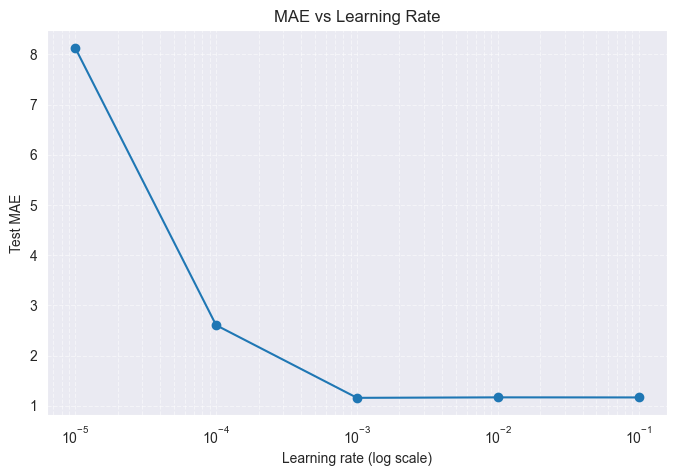

In [19]:
# Tuning learning rate!

learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

# Fix epochs and batch size
epochs = 1000
batch_size = 32

results = []

for lr in learning_rates:
    model = LinearRegression(
        learning_rate=lr,
        epochs=epochs,
        batch_size=batch_size,
    )
    
    model.fit(X_train, Y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(Y_test, preds)
    
    results.append((lr, mae))
    print(f"lr={lr:<6} → MAE = {mae:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(learning_rates, [i[1] for i in results], marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel('Learning rate (log scale)')
plt.ylabel('Test MAE')
plt.title('MAE vs Learning Rate')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()

10^-3 looks like a good balance between precision and speed

#### Batch size


bs=8 → MAE = 1.1582
bs=16 → MAE = 1.1612
bs=32 → MAE = 1.1615
bs=64 → MAE = 1.1608
bs=128 → MAE = 1.1627


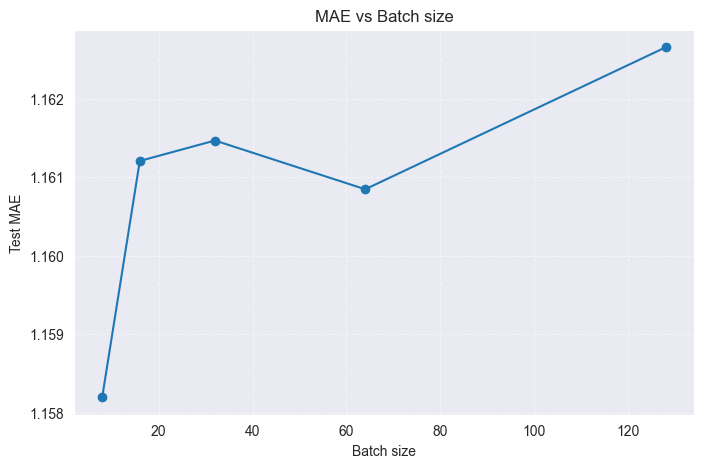

In [20]:
# Tuning batch size!

learning_rate = 1e-3
epochs = 1500

batch_sizes = [8, 16, 32, 64, 128]

results = []

for bs in batch_sizes:
    model = LinearRegression(
        learning_rate=learning_rate,
        epochs=epochs,
        batch_size=bs,
    )
    
    model.fit(X_train, Y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(Y_test, preds)
    
    results.append((bs, mae))
    print(f"bs={bs} → MAE = {mae:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(batch_sizes,  [i[1] for i in results], marker='o', linestyle='-')
plt.xlabel('Batch size')
plt.ylabel('Test MAE')
plt.title('MAE vs Batch size')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()

The difference between batch sizes isn't statistically significant, as long as you don't choose a value too small or too big. I'll stick with 32 here.

#### Epochs count

ep=250 → MAE = 1.2057
ep=300 → MAE = 1.1739
ep=500 → MAE = 1.1608
ep=1000 → MAE = 1.1609
ep=1500 → MAE = 1.1617
ep=2000 → MAE = 1.1604
ep=2500 → MAE = 1.1613
ep=3000 → MAE = 1.1612


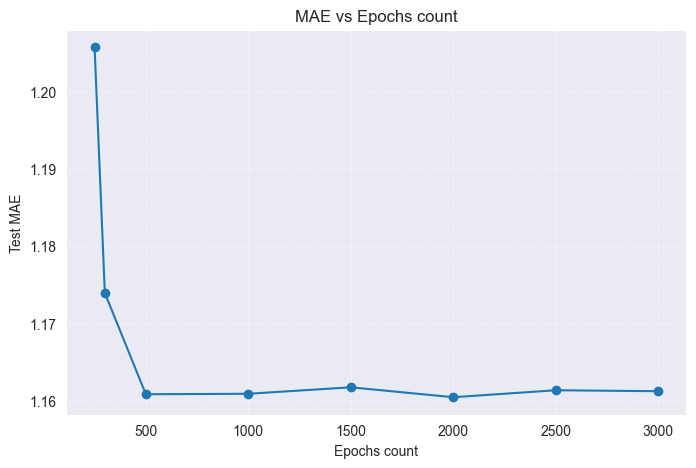

In [21]:
# Tuning # of epochs!

learning_rate = 1e-3
batch_size = 32

epochs = [250, 300, 500, 1000, 1500, 2000, 2500, 3000]

results = []

for ep in epochs:
    model = LinearRegression(
        learning_rate=learning_rate,
        epochs=ep,
        batch_size=batch_size,
    )
    
    model.fit(X_train, Y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(Y_test, preds)
    
    results.append(mae)
    print(f"ep={ep} → MAE = {mae:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(epochs, results, marker='o', linestyle='-')
plt.xlabel('Epochs count')
plt.ylabel('Test MAE')
plt.title('MAE vs Epochs count')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()

The regression seems to converge after 500 epochs. I'll keep 1000 in case the number is bigger in other folds.

### K-nearest neighbours tuning
Here we can only tune the k

k=3 → MAE = 1.5273
k=5 → MAE = 1.4691
k=7 → MAE = 1.4379
k=10 → MAE = 1.4106
k=15 → MAE = 1.3763
k=20 → MAE = 1.3564
k=25 → MAE = 1.3402
k=30 → MAE = 1.3375
k=35 → MAE = 1.3385
k=40 → MAE = 1.3407
k=45 → MAE = 1.3432
k=50 → MAE = 1.3495


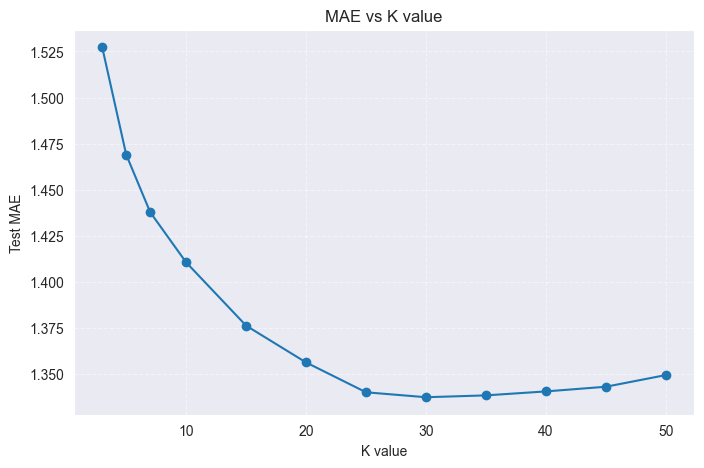

In [22]:
# Tuning k value!

k_grid = [3, 5, 7, 10, 15, 20, 25, 30, 35, 40, 45, 50] 
knn_results = []
for k in k_grid:
    knn = KNNRegression(k=k)
    knn.fit(X_train, Y_train)
    preds = knn.predict(X_test)
    mae = mean_absolute_error(Y_test, preds)

    print(f"k={k} → MAE = {mae:.4f}")
    knn_results.append(mae)

plt.figure(figsize=(8, 5))
plt.plot(k_grid, knn_results, marker='o', linestyle='-')
plt.xlabel('K value')
plt.ylabel('Test MAE')
plt.title('MAE vs K value')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()

Let's stick with 30 here

## K-fold cross-validation

MAE and R^2 benchmarks

In [23]:
k = 5  # Number of folds
kf = sklearn.model_selection.KFold(n_splits=k, shuffle=True, random_state=42)



models = {
    'SKLearn LinearRegression': SKLinear(),
    'MiniBatch GD LinearRegression': LinearRegression(
                                     learning_rate=1e-3,
                                     batch_size=32,
                                     epochs=1000
                                ),
    'KNNRegression (k=30)': KNNRegression(k=30)
}

mae_scores = {name: [] for name in models}
r_squared = {name: [] for name in models}


for train_index, test_index in kf.split(X):
    X_train, X_test = X_std.astype(np.float64).iloc[train_index], X_std.astype(np.float64).iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    for name, model in models.items():
        model.fit(X_train, Y_train)
        pred= model.predict(X_test)
        mae_scores[name].append(mean_absolute_error(Y_test, pred))
        r_squared[name].append(r2_score(Y_test, pred))        

for name in models:
    print(f"--- {name} ---")
    print(f"Average MAE across {k} folds: {np.mean(mae_scores[name]):.4f}")
    print(f"Average R^2 across {k} folds: {np.mean(r_squared[name]):.3f}\n") 

--- SKLearn LinearRegression ---
Average MAE across 5 folds: 1.1994
Average R^2 across 5 folds: 0.636

--- MiniBatch GD LinearRegression ---
Average MAE across 5 folds: 1.1994
Average R^2 across 5 folds: 0.636

--- KNNRegression (k=30) ---
Average MAE across 5 folds: 1.3699
Average R^2 across 5 folds: 0.596



# Conclusion
Both the built-in scikit-learn LinearRegression and our custom mini-batch gradient descent implementation delivered identical results under 5-fold cross-validation, achieving an average MAE of 1.199 and R² of 0.636. This confirms that the custom solver is correct and reaches the same optimum as the closed-form solution.

The KNN regressor with k = 30 was less accurate, with an average MAE of 1.370 and R² of 0.596, showing that a global linear relationship among attendance and study hours explains more variance than local averaging in this dataset.

A well-tuned linear model therefore offers the best combination of prediction accuracy, interpretability and efficiency for forecasting exam scores here.

